In [39]:
import csv
import geopandas as gpd
import pandas as pd
import shapely
from matplotlib.pyplot import figure
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [36]:
neighborhoods = gpd.read_file('community-areas.geojson')
census_income_data = gpd.read_file('census-tracts-2000.geojson')

In [13]:
def getx(pt):
    return pt.coords[0][0]

def gety(pt):
    return pt.coords[0][1]

In [14]:
ids = []
date = []
ptype = []
desc = []
locdesc = []
arrest = []
community_area = []
geometry = []

In [15]:
chunkfiles: list = ['crimes-2010-2011-0.csv', 'crimes-2010-2011-1.csv']

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        for row in crimes_fh:
            if "IUCR" in row or '"(41' not in row:
                # Ignore the header row and rows missing GPS coordinates
                continue
            else:
                row = row.replace(',,',',<empty>,').replace(')"','').rstrip()
                row = row.lstrip('"(')
                fields = row.split(',')
                ids.append(fields[0])
                date.append(fields[2].split(' ')[0])
                ptype.append(fields[5])
                desc.append(fields[6])
                locdesc.append(fields[7])
                arrest.append(fields[8])
                community_area.append(fields[9])
                lat = float(fields[-3].lstrip('"('))
                lon = float(fields[-4].rstrip(')"'))
                geometry.append(shapely.geometry.point.Point(lat, lon))

In [16]:
data = {
        'date': pd.Series(date, index=ids),
        "primary type": pd.Series(ptype, index=ids),
        "description": pd.Series(desc, index=ids),
        "location description": pd.Series(locdesc, index=ids),
        "arrest": pd.Series(arrest, index=ids),
        "community area": pd.Series(community_area, index=ids),
        "geometry": pd.Series(geometry, index=ids)
        }

In [97]:
crimes = gpd.GeoDataFrame(data, index=ids)
print(crimes['primary type'].unique())

['BURGLARY' 'OFFENSE INVOLVING CHILDREN' 'OTHER OFFENSE'
 'CRIM SEXUAL ASSAULT' 'SEX OFFENSE' 'THEFT' 'DECEPTIVE PRACTICE'
 'ROBBERY' 'BATTERY' 'ASSAULT' 'NARCOTICS' 'ARSON' 'MOTOR VEHICLE THEFT'
 'WEAPONS VIOLATION' 'CRIMINAL DAMAGE' 'PUBLIC PEACE VIOLATION'
 'PROSTITUTION' 'CRIMINAL TRESPASS' 'GAMBLING'
 'INTERFERENCE WITH PUBLIC OFFICER' 'LIQUOR LAW VIOLATION' 'KIDNAPPING'
 'STALKING' 'INTIMIDATION' 'OBSCENITY' 'OTHER NARCOTIC VIOLATION'
 'PUBLIC INDECENCY' 'HOMICIDE' 'NON-CRIMINAL']


Potential slices:
* Property (burglary, theft, robbery, etc.)
* Bodily (sexual assault, sex offense, battery, assault, kidnapping, etc.)
* Vice (gambling, prostitution, liquor law, narcotics, etc.)

In [18]:
x = list(crimes.geometry.apply(getx))
y = list(crimes.geometry.apply(gety))
heatmap, xedges, yedges = np.histogram2d(y, x, bins=(100, 100))
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

In [27]:
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, 1, mode='nearest')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


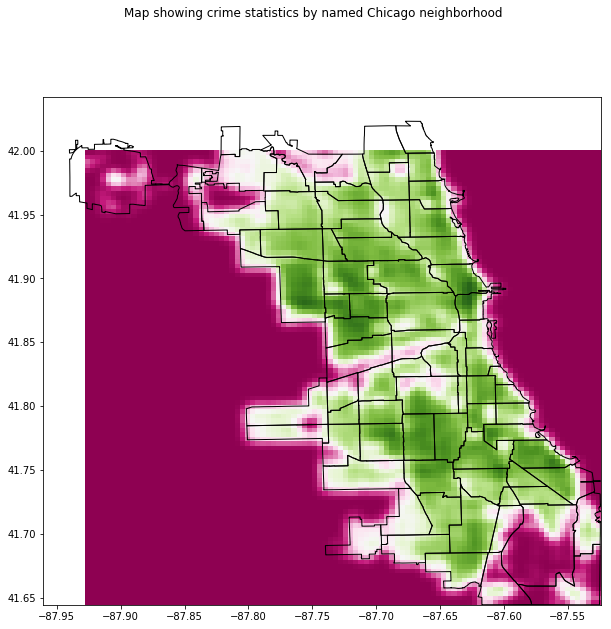

In [28]:
fig, ax = plt.subplots()
fig.suptitle('Map showing crime statistics by named Chicago neighborhood')
ax.set_aspect('equal')
fig.set_size_inches(10,10)

plt.imshow(logheatmap, cmap="PiYG", extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
plt.show()

I don't understand it. If I have the pyplot figure variable named fig, everything works as expected.

In [ ]:
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax3 = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 100)
Y = np.arange(0, 100)
X, Y = np.meshgrid(X, Y)
Z = logheatmap
print(Z.min())
print(Z.max())

# Plot the surface.
surf = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=.5)

# Customize the z axis.
ax3.set_zlim(-4, 7)
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

But renaming it from fig to fig3, and leaving everything else the same, the plot breaks.

In [ ]:
fig3 = plt.figure()
ax = fig.gca(projection='3d')
print(type(ax))
ax3 = fig.gca(projection='3d')
print(type(ax3))

# Make data.
X = np.arange(0, 100)
Y = np.arange(0, 100)
X, Y = np.meshgrid(X, Y)
Z = logheatmap
print(Z.min())
print(Z.max())

# Plot the surface.
surf = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=.5)

# Customize the z axis.
ax3.set_zlim(-4, 7)
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig3.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [40]:
with open("sorted-census-tract-median-household-income.csv", "r") as tract_income:
    tract_income_list = list(csv.DictReader(tract_income))

In [41]:
tract_info_df = pd.DataFrame(tract_income_list)
with_incomes = pd.merge(census_income_data, tract_info_df, on="census_tra")

[0 1 2 3 4 5]


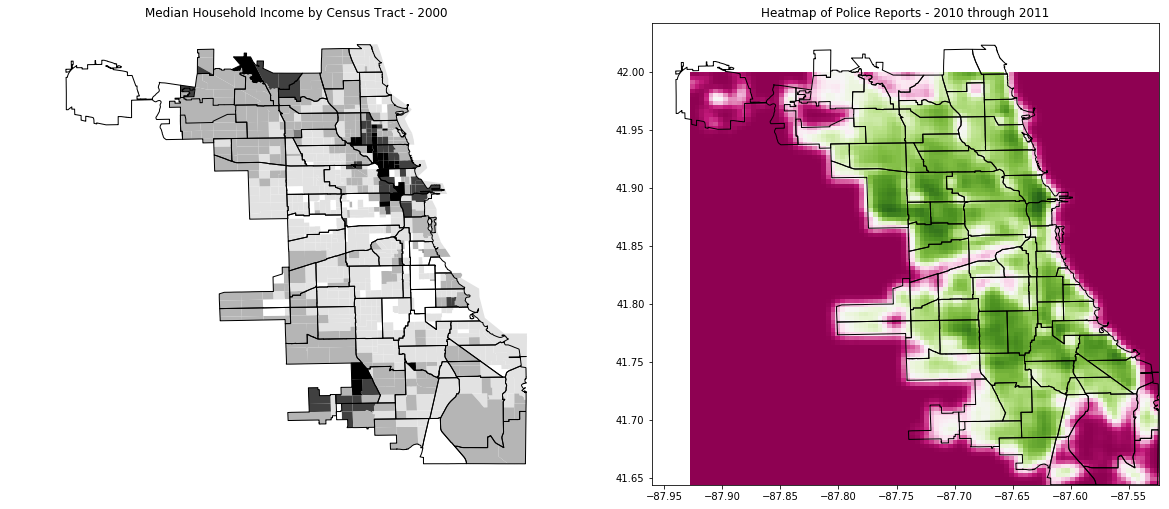

In [96]:
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib.ticker import MaxNLocator

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 20))

income_ranges = np.array(["",
                          "$0      - $20,000",
                          "$20,001 - $40,000",
                          "$40,001 - $60,000",
                          "$60,001 - $80,000",
                          "$80,001 +"
                         ])

ax.set_aspect('equal')
ax.set_title('Median Household Income by Census Tract - 2000')
ax.axis("off")

#cMap = ListedColormap(["#333333", "#555555", "#999999", "#BBBBBB", "#EEEEEE"])
cMap = plt.get_cmap('Greys')
print(cMap)

levels = np.linspace(0, 5, 6, dtype=int)
print(levels)

norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cMap.N, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: income_ranges[::-1][norm(x)])

#wi_plot = with_incomes.plot(ax=ax, column="income_range",  cmap=cMap, legend=True)
with_incomes.plot(ax=ax, column="income_range",  cmap=cMap)
#cb1 = matplotlib.colorbar.ColorbarBase(cmap="Greys",
#                                       norm=norm,
#                                       orientation='horizontal', ax=ax)
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

#cb1.set_label(income_ranges, fontsize=6)


ax2.set_aspect('equal')
ax2.set_title('Heatmap of Police Reports - 2010 through 2011')
plt.imshow(logheatmap, cmap="PiYG", extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax2, edgecolor='black', color='none')
plt.show()

In [ ]:
cb1.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(income_ranges):
    cb1.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='bottom')
cb1.ax.get_yaxis().labelpad = 15
cb1.ax.set_ylabel('Income Ranges') #, rotation=270)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(with_incomes.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(with_incomes.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

plt.tight_layout()


#bounds = np.linspace(0,6,5)
#cb = plt.colorbar(wi_plot, spacing='proportional', ticks=bounds)
#cb = plt.colorbar(ax=ax, spacing='proportional', ticks=bounds)
#cb.set_label('Custom cbar')
#ax.set_title('Discrete color mappings')


#plt.colorbar(ax=ax, format=fmt)

# add the colorbar to the figure
#cbar = fig.colorbar(sm, ax=ax)